In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn

import nibabel as nib
from nilearn import maskers
from nilearn.plotting import plot_stat_map
from neurovlm.data import data_dir

from neurovlm.models import NeuroAutoEncoder
from neurovlm.train import Trainer, which_device
device = which_device()

# Autoencoder

The first step is to reduce the dimensionality of the 28k MNI space neuro vector. Several work uses difumo. Instead, we use an autoencoder to map from $d=28,000$ to a $k=384$ latent space. 

## Load Neurovectors

Results from the coordinate smoothing notebook.

In [ ]:
# Load vectors from 01_coordinate.ipynb
neuro_vectors, pmids = torch.load(
    data_dir / "neuro_vectors.pt", weights_only=False,
).values()

# Filter for studies with less than 100 coordinates
df_coords = pd.read_parquet(data_dir / "coordinates.parquet")
counts = df_coords[df_coords['pmid'].isin(pmids)]["pmid"].value_counts()
mask = pd.Series(pmids).isin(counts.index[counts <= 100].values)
pmids = np.array(pmids[mask])
neuro_vectors = neuro_vectors[mask]

## Training

Train an autoencoder on the neuro-vectors.

1. Encoder: Neuro-vector to low-dimensional (384) latent vector / embedding space
2. Decoder: Latent vector to produces MNI space predictions.

Training is complete in two stages:

1. Initial training anywhere neurovectors > 0
2. Additional training to shrink the size of activations closer to targets

In [ ]:
# Train/test/validation split
inds = torch.arange(len(pmids))
train_inds, test_inds = train_test_split(
    inds, train_size=0.8, random_state=0
)
test_inds, val_inds = train_test_split(
    test_inds, train_size=0.5, random_state=1
)
torch.save({
    "train": pmids[train_inds],
    "test": pmids[test_inds],
    "val": pmids[val_inds]
}, data_dir / "pmids_split.pt")

In [4]:
trainer = Trainer(
    NeuroAutoEncoder(seed=0, out="logit"),
    n_epochs=101,
    batch_size=256,
    lr=5e-5,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.AdamW,
    X_val=neuro_vectors[val_inds],
    device="auto",
    interval=5
)

# Fit
trainer.fit(neuro_vectors[train_inds])

# Save
trainer.save(data_dir / "autoencoder.pt")

# Unpack
autoencoder = trainer.model

Epoch: -1, val loss: 0.69322
Epoch: 0, val loss: 0.17891
Epoch: 5, val loss: 0.091533
Epoch: 10, val loss: 0.087023
Epoch: 15, val loss: 0.084486
Epoch: 20, val loss: 0.081933
Epoch: 25, val loss: 0.078111
Epoch: 30, val loss: 0.076358
Epoch: 35, val loss: 0.075639
Epoch: 40, val loss: 0.074093
Epoch: 45, val loss: 0.073271
Epoch: 50, val loss: 0.072556
Epoch: 55, val loss: 0.071442
Epoch: 60, val loss: 0.070404
Epoch: 65, val loss: 0.06953
Epoch: 70, val loss: 0.068742
Epoch: 75, val loss: 0.0679
Epoch: 80, val loss: 0.067211
Epoch: 85, val loss: 0.066509
Epoch: 90, val loss: 0.065869
Epoch: 95, val loss: 0.065255
Epoch: 100, val loss: 0.064734


## Save Latent Vectors

In [ ]:
torch.load(data_dir / "autoencoder.pt")

In [5]:
# Encode neuro vectors
with torch.no_grad():
    latent_neuro = autoencoder.encoder(neuro_vectors.to(device)).detach()

torch.save(dict(latent=latent_neuro, pmid=pmids), data_dir / "latent_neuro.pt")

## Results

Plot an example.

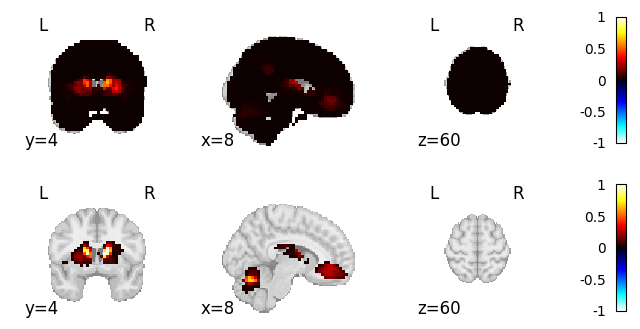

In [6]:
import matplotlib.pyplot as plt

mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()

# Prediction
idx = 0
img_pred = masker.inverse_transform(
    torch.sigmoid(autoencoder.cpu()(neuro_vectors.cpu()[val_inds][idx])).detach()
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))

plot_stat_map(img_pred, cut_coords=np.array([8, 4, 60]),
              cmap="cold_hot", vmin=-1, vmax=1, threshold=0.0, draw_cross=False, axes=axes[0]);

# ALEKernel target
plot_stat_map(masker.inverse_transform(neuro_vectors.cpu().numpy()[val_inds][idx]), cut_coords=np.array([8, 4, 60]),
              cmap="cold_hot", vmin=-1, vmax=1, threshold=0.01, draw_cross=False, axes=axes[1]);